In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import torch
import pytorch_lightning as pl

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from data.dataset import PDEDataset, PDEDataModule
from data.utils import d_to_LT

from model.setup import setup_model
from model.networks.fno import FNO1d
from model.learner import Learner

from viz.plot_pde_data import plot_1ds, plot_1d_dict

from run import parse_options, main
from data.utils import d_to_coords

from data.generate_data import GeneratePDEData
from data.pde_collection import CollectionPDE_Pseudospectral
from viz.plot_pde_data import plot_1d, plot_1ds, plot_1d_dict
from data.utils import save_obj, load_obj

from data.lpda_data_aug import fourier_shift
from data.pde_data_aug import pde1_u2, pde1_u3, pde1_u4, pde1_u5, pde1_u6, KdV_u2, KdV_u3, KdV_u4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def calculate_mse(u_cross, u_new):
    mse = np.mean((u_cross - u_new)**2)
    normed_mse = mse / np.mean(u_cross**2)
    root_normed_mse = np.sqrt(normed_mse)
    return root_normed_mse

def plot_diffs(us):
    u_org, u_aug, u_cross = us
    vmin, vmax = np.min(us), np.max(us)
    fig, axes = plt.subplots(1, 3, figsize=(8,2))
    axes[0].imshow(u_org, cmap = 'PuOr_r', aspect = 'auto', vmin=vmin, vmax=vmax) #, extent=[0,Xmax,0,Tmax])
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('t')
    axes[0].set_title('Original')

    axes[1].set_title('Data aug')
    axes[1].imshow(u_aug, cmap = 'PuOr_r', aspect = 'auto', vmin=vmin, vmax=vmax) #, extent=[0,Xmax,0,Tmax])
    axes[1].set_xlabel('x')

    axes[2].set_title('Solver')
    axes[2].imshow(u_cross, cmap = 'PuOr_r', aspect = 'auto', vmin=vmin, vmax=vmax) #, extent=[0,Xmax,0,Tmax])
    axes[2].set_xlabel('x')

    # for ax in axes:
    #     ax.set_anchor('S')
    plt.show()

def report_mses(mses):
    # Without minus in epsilon * t in gallileo
    print(f'Mean MSE:   {np.mean(mses):.4f}', )
    print(f'Std MSE:    {np.std(mses):.4f}', )
    print(f'Median MSE: {np.median(mses):.4f}', )

    plt.hist(mses)
    plt.xlabel('Root normalized mean squared error')
    plt.ylabel('Count')
    plt.title('Difference between augmented and crosscheck solution')
    plt.yscale('log')
    plt.show()

def plt_imshow(data, same_scale = False, titles = None):

    # if data is list
    if isinstance(data, list):
        data = torch.stack(data)

    vmin, vmax =( np.min(data), np.max(data)) if same_scale else (None, None)
    fig, axs = plt.subplots(1, len(data), figsize=(8,2))

    axs = axs if isinstance(axs, np.ndarray) else [axs]

    for i, d in enumerate(data):
        axs[i].imshow(d, cmap = 'PuOr_r', aspect = 'auto', vmin=vmin, vmax=vmax)
        if titles is not None:
            axs[i].set_title(titles[i])

    plt.show()

def calc_crosscheck(u_new, x_new, t_new, pde_func, tol):
    Nt, Nx = u_new.shape
    # Get new coords
    X_new = torch.stack((x_new, t_new), dim = -1)

    Xmax_cross = (X_new[0, -1, 0] - X_new[0, 0, 0])# * (Nx+1) / Nx
    Tmax_cross = X_new[-1, 0, 1] - X_new[0, 0, 1]
    t_cross = np.linspace(0, Tmax_cross.item(), Nt)

    sol_cross = solve_ivp(
        fun=pde_func, 
        t_span=[t_cross[0], t_cross[-1]], 
        y0=u_new[0, :], 
        method='Radau', 
        t_eval=t_cross, 
        atol=tol, 
        rtol=tol
        )
    u_cross = sol_cross.y.T
    return u_cross


In [18]:
args = parse_options(notebook=True)
args.pde_name = 'pde1'
# args.seed = 1
# args.version = f'{args.pde_name}_seed{args.seed}'
args.version = 'test'
args.train = True
args.num_workers = 7
args.local = True
args.batch_size = 2
args.do_return = True

In [70]:
model, trainer, datamodule = main(args)

datamodule.setup()
dataset_train = datamodule.train_dataloader().dataset

# Get original coords
# u, dx, dt = dataset_train[1]


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [87]:
dataset_train[1]

tensor(1.0977)
tensor(0.0155)
tensor(0.0008)
tensor(0.0004)
tensor(-0.2824)


(tensor([[-1.4870e+00, -1.5418e+00, -1.5950e+00,  ..., -3.3288e-07,
          -3.0665e-07, -2.8176e-07],
         [-1.4847e+00, -1.5393e+00, -1.5923e+00,  ..., -3.4093e-07,
          -3.1411e-07, -2.8865e-07],
         [-1.4824e+00, -1.5368e+00, -1.5896e+00,  ..., -3.4914e-07,
          -3.2171e-07, -2.9568e-07],
         ...,
         [-1.4042e+00, -1.4529e+00, -1.5002e+00,  ..., -7.6541e-07,
          -7.0827e-07, -6.5385e-07],
         [-1.4020e+00, -1.4506e+00, -1.4977e+00,  ..., -7.8175e-07,
          -7.2348e-07, -6.6796e-07],
         [-1.3998e+00, -1.4483e+00, -1.4953e+00,  ..., -7.9839e-07,
          -7.3896e-07, -6.8234e-07]]),
 tensor(0.2462),
 tensor(0.9927))

In [20]:
L, Nx = 64, 256
T, Nt = 40, 40
tol = 1e-6


tensor(0.1877)
tensor(0.0286)
tensor(0.0016)
tensor(0.0004)
tensor(-0.0153)


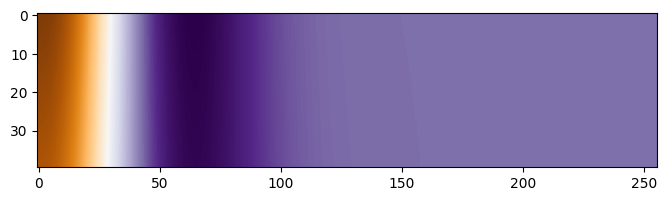

In [67]:
i = 0
u, dx, dt = dataset_train[i]
plt_imshow([u])

In [7]:


pde_collection = CollectionPDE_Pseudospectral(L = L).collection
pde_func = pde_collection[args.pde_name]

tensor(-0.4738)
tensor(0.0450)
tensor(-0.0009)
tensor(-0.0004)
tensor(-0.1351)


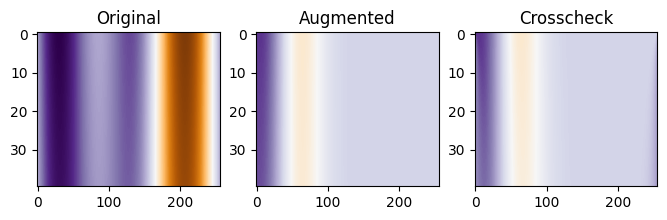

tensor(0.0468)
tensor(-0.0494)
tensor(-0.0039)
tensor(-0.0001)
tensor(-0.0765)


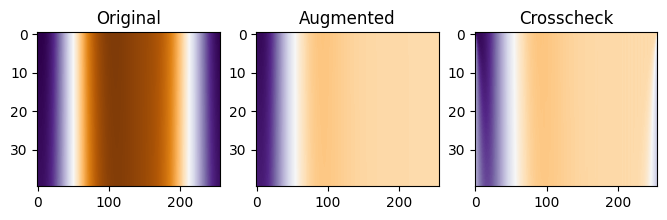

tensor(-1.1063)
tensor(0.0205)
tensor(-0.0026)
tensor(-0.0004)
tensor(0.0924)


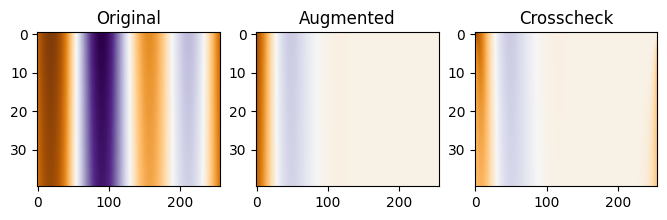

tensor(-0.2850)
tensor(0.0499)
tensor(-0.0038)
tensor(0.0002)
tensor(-0.4100)


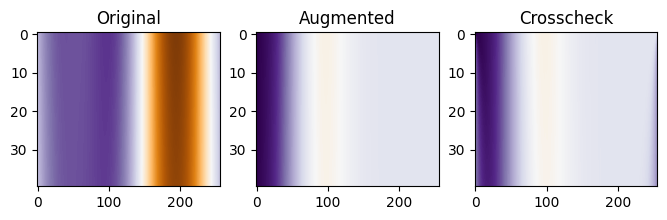

tensor(-1.3929)
tensor(-0.0327)
tensor(-0.0050)
tensor(-0.0002)
tensor(-0.4189)


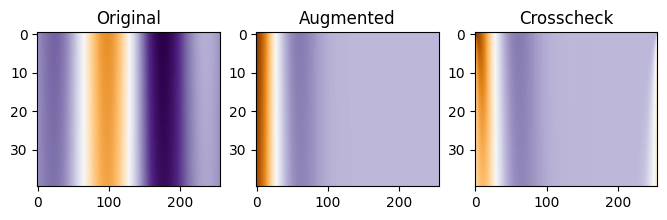

In [51]:
def augment(u, x, t):

    u_new, x_new, t_new = u.clone(), x.clone(), t.clone()

    # u_new, x_new, t_new = KdV_u2(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) ) # 
    # u_new, x_new, t_new = KdV_u3(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 2) # 
    # u_new, x_new, t_new = KdV_u4(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 0.1) # Max scale is important!

    u_new, x_new, t_new = pde1_u2(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 3 ) #  
    u_new, x_new, t_new = pde1_u3(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 0.1) # have to be low
    u_new, x_new, t_new = pde1_u4(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 0.01) # have to be low
    u_new, x_new, t_new = pde1_u5(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 0.001) # kinda okish
    u_new, x_new, t_new = pde1_u6(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 1.) # 



    u_new = u_new.numpy()
    return u_new, x_new, t_new


for i in range(5):
    # Get original coords
    u, dx, dt = dataset_train[i]
    X = d_to_coords(u, dx, dt)
    x, t = X.permute(2, 0, 1)[:2]

    u_new, x_new, t_new = augment(u, x, t)
    u_cross = calc_crosscheck(u_new, x_new, t_new, pde_func, tol)
    us = np.stack((u.numpy(), u_new, u_cross))
    plt_imshow(us, titles = ['Original', 'Augmented', 'Crosscheck'], same_scale = True)

In [8]:
assert False

AssertionError: 

In [ ]:
def augment(u, x, t, eps1, eps2, eps3, esp4, eps5, eps6, method = 0):

    u_new, x_new, t_new = u.clone(), x.clone(), t.clone()

    # u_new, x_new, t_new = pde1_u3(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 1 )
    # u_new, x_new, t_new = pde1_u4(u_new, x_new, t_new, eps = eps4, method = method )    
    # u_new, x_new, t_new = pde1_u(u_new, x_new, t_new, eps = eps6)    

    # u_new, x_new, t_new = KdV_u2(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) ) # time
    # u_new, x_new, t_new = KdV_u3(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) ) # space
    # u_new, x_new, t_new = KdV_u4(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 0.) # galileo


    u_new = u_new.numpy()
    return u_new, x_new, t_new

n_methods = 1
n_samples = 5

methods = range(n_methods)
mses = np.zeros((n_methods, n_samples))

for sample_id in tqdm(range(n_samples)):
    eps1 = (torch.rand(()) - 0.5)
    eps2 = (torch.rand(()) - 0.5)
    eps3 = (torch.rand(()) - 0.5) * 2
    eps4 = (torch.rand(()) - 0.5) * 0.01
    eps5 = (torch.rand(()) - 0.5) 
    eps6 = (torch.rand(()) - 0.5) * .0001
    for method in methods:
        u_new, x_new, t_new = augment(u, x, t, eps1, eps2, eps3, eps4, eps5, eps6, method = method)
        u_cross = calc_crosscheck(u_new, x_new, t_new)
        if sample_id == 0 or True:
        # if sample_id == 0:
            print(method)
            us = u.numpy(), u_new, u_cross
            plot_diffs(us)
        mse = calculate_mse(u_cross, u_new)
        mses[method, sample_id] = mse

# print(mses)
# plot_diffs(u, u_new, u_cross)
# report_mses(mses)

# mses = np.array(mses)
# mses_diff = mses[0] - mses[1]

In [ ]:
assert False

In [ ]:
# def pde_u2(u, x, t, eps):
#     x_new = x
#     t_new = t
#     # u_new = fourier_shift(u, eps = -eps, dim = -1)
#     u_new = (fourier_shift(u.unsqueeze(0), eps, dim = -1)).squeeze(0)
#     return u_new, x_new, t_new

# def pde1_u3(u, x, t, eps):
#     x_new = x * torch.exp(-eps)
#     t_new = t * torch.exp(-2 * eps)
#     u_new = u
#     return u_new, x_new, t_new

# def pde1_u4(u, x, t, eps):
#     d = - 2*eps * (t[:, 0] / L)
#     eps_u = - eps
#     x_new = x
#     t_new = t

#     u_mult = torch.exp(-eps_u * (x + -eps_u * t) / 0.1)
#     u_new = (fourier_shift(u, eps=d[:, None], dim=-1)).squeeze(0) * u_mult
#     return u_new, x_new, t_new

# def pde1_u5(u, x, t, eps):

#     eps = np.abs(eps)

#     eps_u = - eps
#     shift1 = 1 + 4*eps * t
#     shift1_u = 1 + 4*-eps_u * t
#     u_mult = torch.exp( (-eps * x**2) / (0.1 * shift1_u) ) / torch.sqrt(shift1_u)

#     x_new = x / shift1 
#     t_new = t / shift1 

#     u_new = u * u_mult
#     return u_new, x_new, t_new

# def pde1_u6(u, x, t, eps):
#     eps_u = - eps
#     x_new = x
#     t_new = t
#     u_new = torch.exp(eps_u) * u
#     return u_new, x_new, t_new


# def KdV_u2(u, x, t, eps):
#     x_new = x
#     t_new = t
#     # u_new = fourier_shift(u, eps = -eps, dim = -1)
#     u_new = (fourier_shift(u.unsqueeze(0), eps, dim = -1)).squeeze(0)
#     return u_new, x_new, t_new

# def KdV_u3(u, x, t, eps):
#     # scaling
#     d = - eps * (t[:, 0] / L) # minus, t, L are all necessary
#     eps_u = - eps
#     x_new = x
#     t_new = t
#     u_new = (fourier_shift(u, eps=d[:, None], dim=-1) + eps_u).squeeze(0) # minus is necassary
#     return u_new, x_new, t_new

# def KdV_u4(u, x, t, eps):
#     eps_u = - eps
#     x_new = x * torch.exp(-eps)
#     t_new = t * torch.exp(-3 * eps)
#     u_new = u * torch.exp(- 2 * eps_u)
#     return u_new, x_new, t_new

In [ ]:
from data.pde_data_aug import pde1_u3, pde1_u4, pde1_u5, KdV_u1, KdV_u2, KdV_u3_0, KdV_u3_1


def augment(u, x, t, eps1, eps2, eps3, esp4, eps5, eps6, method = 0):

    u_new, x_new, t_new = u.clone(), x.clone(), t.clone()

    # u_new, x_new, t_new = pde1_u3(u_new, x_new, t_new, eps = (torch.rand(()) - 0.5) * 1 )
    # u_new, x_new, t_new = pde1_u4(u_new, x_new, t_new, eps = eps4, method = method )    
    u_new, x_new, t_new = pde1_u5(u_new, x_new, t_new, eps = eps6)    

    # u_new, x_new, t_new = KdV_u1(u_new, x_new, t_new, eps = eps1 ) # time
    # u_new, x_new, t_new = KdV_u2(u_new, x_new, t_new, eps = eps2 ) # space
    
    # if method == 0:
    #     u_new, x_new, t_new = KdV_u3_0(u_new, x_new, t_new, eps = eps3) # galileo
    # elif method == 1:
    #     u_new, x_new, t_new = KdV_u3_1(u_new, x_new, t_new, eps = eps3) # galileo
    # else:
    #     raise ValueError('method must be 0, 1 or 2')

    # u_new, x_new, t_new = KdV_u3(u_new, x_new, t_new, eps = eps3) # galileo


    u_new = u_new.numpy()
    return u_new, x_new, t_new

n_methods = 1
n_samples = 5

methods = range(n_methods)
mses = np.zeros((n_methods, n_samples))

for sample_id in tqdm(range(n_samples)):
    eps1 = (torch.rand(()) - 0.5)
    eps2 = (torch.rand(()) - 0.5)
    eps3 = (torch.rand(()) - 0.5) * 2
    eps4 = (torch.rand(()) - 0.5) * 0.01
    eps5 = (torch.rand(()) - 0.5) 
    eps6 = (torch.rand(()) - 0.5) * .0001
    for method in methods:
        u_new, x_new, t_new = augment(u, x, t, eps1, eps2, eps3, eps4, eps5, eps6, method = method)
        u_cross = calc_crosscheck(u_new, x_new, t_new)
        if sample_id == 0 or True:
        # if sample_id == 0:
            print(method)
            us = u.numpy(), u_new, u_cross
            plot_diffs(us)
        mse = calculate_mse(u_cross, u_new)
        mses[method, sample_id] = mse

# print(mses)
# plot_diffs(u, u_new, u_cross)
# report_mses(mses)

# mses = np.array(mses)
# mses_diff = mses[0] - mses[1]

In [ ]:
print(np.mean(mses, axis = 1), np.std(mses, axis = 1))

for method in methods:
    plt.scatter(method * np.ones_like(mses[method]), mses[method])
    plt.hlines(np.mean(mses[method]), method - 0.2, method + 0.2, linestyle = ':', color = 'k')
    plt.hlines(np.mean(mses[method]) + np.std(mses[method]), method - 0.2, method + 0.2, linestyle = ':', color = 'k')
    plt.hlines(np.mean(mses[method]) - np.std(mses[method]), method - 0.2, method + 0.2, linestyle = ':', color = 'k')
    
plt.xticks(methods, methods)
plt.xlabel('Method')
plt.show()

# plt.plot(mses_diff)
# plt.hlines(0, 0, len(mses_diff), linestyle = ':', color = 'k')
# plt.show()

In [ ]:
assert False

In [ ]:
us, dx, dt = dataset_train[:10][0], dataset_train[0][1].item(), dataset_train[0][2].item()
us = us.view(2, 5, us.shape[1], us.shape[2])
plot_1ds(us, dx, dt)

assert False

In [ ]:
from data.lpda_data_aug import SpaceTranslate, Scale, Galileo, to_coords
from data.utils import d_to_coords

generators = [
    SpaceTranslate(max_x_shift=1),
    Galileo(max_velocity=0.1),
    Scale(max_scale=1),
]

def augment(u, dx, dt):
    # Get coordinates
    X = d_to_coords(u, dx, dt)

    # Augment
    sol = (u, X)
    for g in generators:
        sol = g(sol, shift = 'fourier')
    u, X = sol

    # Get new coordinates
    dx = X[0, 1, 0] - X[0, 0, 0]
    dt = X[1, 0, 1] - X[0, 0, 1]

    return u, dx, dt

u, dx, dt = us[0], dxs[0], dts[0]
augment(u, dx, dt)

In [ ]:
Nt, Nx = u.shape
x = torch.arange(0, Nx) * dx
t = torch.arange(0, Nt) * dt

X = to_coords(x, t)

In [ ]:
sol = (u, X)
for g in generators:
    sol = g(sol, shift = 'fourier')
u, X = sol

In [ ]:
x = X[0, 1, 0] - X[0, 0, 0]
dt = X[1, 0, 1] - X[0, 0, 1]
dx, dt

### LPSDA

In [ ]:
from data.lpda_data_aug import SpaceTranslate, Scale, Galileo, to_coords

generators = [
    SpaceTranslate(max_x_shift=1),
    Galileo(max_velocity=0.1),
    Scale(max_scale=1),
]

In [ ]:
us.shape

In [ ]:
# set to inference mode
model.eval()


In [ ]:
model = model.eval()
y_pred, y = model(batch)
y_pred = y_pred.detach().cpu().numpy()

In [ ]:
y_pred.shape

In [ ]:
model.log_fig(batch, y_pred.detach())